<a href="https://colab.research.google.com/github/rudysemola/ComputerVisionEngineer-ImageClassification/blob/main/ImageClassification_plant_village.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification (plant_village)

## Set up

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

In [2]:
import matplotlib.pyplot as plt

In [3]:
print(tf.__version__)

2.4.1


## Load Dataset
Using TF Dataset

In [13]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'plant_village',
    split=['train[:10%]', 'train[10%:15%]', 'train[15%:20%]'],
    with_info=True,
    as_supervised=True,
)

Shuffling and writing examples to /root/tensorflow_datasets/plant_village/1.0.2.incompleteG1B5SS/plant_village-train.tfrecord


Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.


In [14]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

38


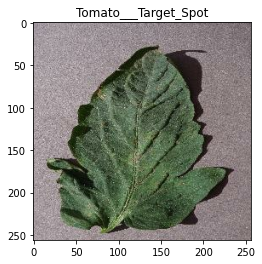

In [15]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

## Data Preparation and Preprocessing
NOTE: remember to batch, shuffle, and configure each dataset for performance.

Can Do rescale, resize/normalization od data, data augmentation as preprocessing

In [16]:
#
AUTOTUNE = tf.data.AUTOTUNE

#
def prepare_data(ds, shuffle=False):
  # (Resize and, HERE...) rescale all datasets
  #ds = ds.map(lambda x, y: (rescale_data(x), y), num_parallel_calls=AUTOTUNE)
  #
  ds = ds.cache()
  if shuffle:
    ds = ds.shuffle(1000)
  ds = ds.batch(batch_size)
  # Use data augmentation only on the training set (HERE...)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [17]:
train_ds = prepare_data(train_ds)
val_ds = prepare_data(val_ds)
test_ds = prepare_data(test_ds)

## Model part

Set up MobileNetV2 & Create a classifier model

In [4]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
import numpy as np
%matplotlib inline

In [49]:
batch_size = 32
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

In [50]:
# Create the base model from the pre-trained model MobileNet V2
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input 
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(224, 224)
])
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [ ]:
"Prove - test"
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

### Feature Extraction

In [60]:
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax', name="fc_out")
#prediction_layer = tf.keras.layers.Dense(num_classes)

In [ ]:
"Prove - test"
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

In [61]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = preprocess_input(x) # x
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [62]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [63]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_6 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_6 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1280)              0   

### Run MobileNetV2 Training

In [45]:
def plot_hist(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

In [64]:
"prove - test"
initial_epochs = 2

loss0, accuracy0 = model.evaluate(val_ds)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

ValueError: ignored

In [43]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/2
170/170 [==============================] - 15s 74ms/step - loss: 2.4956e-06 - accuracy: 0.0195 - val_loss: 2.4611e-06 - val_accuracy: 0.0184
Epoch 2/2
170/170 [==============================] - 12s 70ms/step - loss: 2.4956e-06 - accuracy: 0.0208 - val_loss: 2.4611e-06 - val_accuracy: 0.0184


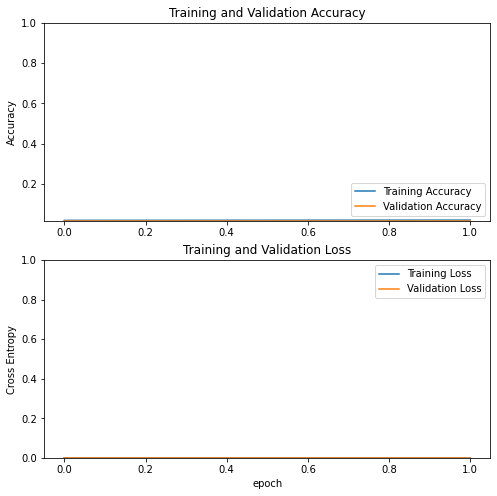

In [46]:
plot_hist(history)

In [ ]:
"""
history = model.fit_generator(
      train_ds,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=val_ds,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)
"""

### Inference and prediction (evaluate model)

In [47]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

85/85 [==============================] - 5s 53ms/step - loss: 2.5120e-06 - accuracy: 0.0155
Test accuracy : 0.015463917516171932


In [ ]:
#TODO... with specific (custom better) image

### Plus code
- save model
- download tr model
- load
- inference

In [ ]:
#TODO...